# CPG Industry - Personalization Workshop

Welcome to the CPG Industry Personalization Workshop. In this module we're going to be adding three core personalization features powered by [Amazon Personalize](https://aws.amazon.com/personalize/): related product recommendations on the product detail page, personalized recommendations, and personalized ranking of items. This will allow us to give our users targeted recommendations based on their activity.
This workshop reuse a lot of code and behaviour from Retail Demo Store, if you want to expand to explore retail related cases take a look at: https://github.com/aws-samples/retail-demo-store

Recommended Time: 2 Hours

## Setup

To get started, we need to perform a bit of setup. Walk through each of the following steps to configure your environment to interact with the Amazon Personalize Service.

### Import Dependencies and Setup Boto3 Python Clients

Throughout this workshop we will need access to some common libraries and clients for connecting to AWS services. We also have to retrieve Uid from a SageMaker notebook instance tag.

In [1]:
# Import Dependencies

import boto3
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import requests
import csv
import sys
import botocore
import uuid

from packaging import version
from random import randint
from botocore.exceptions import ClientError

%matplotlib inline

# Setup Clients

personalize = boto3.client('personalize')
personalize_runtime = boto3.client('personalize-runtime')
personalize_events = boto3.client('personalize-events')
s3 = boto3.client('s3')

with open('/opt/ml/metadata/resource-metadata.json') as f:
  data = json.load(f)
sagemaker = boto3.client('sagemaker')
sagemakerResponce = sagemaker.list_tags(ResourceArn=data["ResourceArn"])
for tag in sagemakerResponce["Tags"]:
    if tag['Key'] == 'Uid':
        Uid = tag['Value']
        break

### Implement some visualization functions for displaying information of the products in a dataframe

Throughout this workshop we will need to search information of products several times, this function will help us to do it without repeating the same code.

In [2]:
def search_items_in_dataframe(item_list):
    df = pd.DataFrame() 
    for x in range(len(item_list)):
        temp = products_dataset_df.loc[products_dataset_df['ITEM_ID'] == int(item_list[x]['itemId'])]
        df = df.append(temp, ignore_index=True)
    pd.set_option('display.max_rows', 10)
    return df

### Configure Bucket and Data Output Location

We will be configuring some variables that will store the location of our source data. Substitute the name of the bucket we will create later with your own. 

In [3]:

bucket = "cpg-personalize-datasets"     # Use your own bucket
items_filename = "items.csv"                # Do Not Change
users_filename = "users.csv"                # Do Not Change
interactions_filename = "interactions.csv"  # Do Not Change


## Get, Prepare, and Upload User, Product, and Interaction Data

Amazon Personalize provides predefined recipes, based on common use cases, for training models. A recipe is a machine learning algorithm that you use with settings, or hyperparameters, and the data you provide to train an Amazon Personalize model. The data you provide to train a model are organized into separate datasets by the type of data being provided. A collection of datasets are organized into a dataset group. The three dataset types supported by Personalize are items, users, and interactions. Depending on the recipe type you choose, a different combination of dataset types are required. For all recipe types, an interactions dataset is required. Interactions represent how users interact with items. For example, viewing a product, watching a video, listening to a recording, or reading an article. For this workshop, we will be using a recipe that supports all three dataset types.

First we need to create a bucket to store the datasets for Personalize to consume them. 

Let's get started.

In [ ]:
s3.create_bucket(Bucket=bucket)

#### Download and Explore and clean the Products Dataset

In [ ]:
products_df = pd.read_csv('./items-origin.csv')
pd.set_option('display.max_rows', 5)
products_df


### Clean the product dataset and drop columms we don't need.

First, business sent us this data but the information in the gender_affinity column is not reliable. We are going to replace all the M and F values for a np.nan to avoid noise on our model. 
Also we are going to drop all the columns with non relevant data for us. 
Let's get started.

In [ ]:
products_df['gender_affinity'] = products_df['gender_affinity'].replace('M', np.nan)
products_df['gender_affinity'] = products_df['gender_affinity'].replace('F', np.nan)
products_df = products_df[['id','name','category','type', 'size', 'gender_affinity', 'sugar']]
products_df.info()

#### Prepare products Data

When training models in Amazon Personalize, we can provide meta data about our items. For this workshop we will add each product's category and style to the item dataset. The product's unique identifier is required. Then we will rename the columns in our dataset to match our schema (defined later) and those expected by Personalize. Finally, we will save our dataset as a CSV and copy it to our S3 bucket.

In [ ]:
products_dataset_df = products_df[['id','category','type', 'size', 'sugar']]


In [ ]:
products_dataset_df['category'].unique()

In [ ]:
products_dataset_df = products_dataset_df.rename(columns = {'id':'ITEM_ID','category':'CATEGORY','type':'TYPE', 'size':'SIZE', 'sugar':'SUGAR'}) 


In [ ]:
products_dataset_df.head(5)

In [ ]:
products_dataset_df.to_csv(items_filename, index=False)

#### Download and Explore the Users Dataset

In [ ]:
users_df = pd.read_csv('./users-origin.csv')
pd.set_option('display.max_rows', 5)
users_df

#### Prepare products Data

Similar to the items dataset we created above, we can provide metadata on our users when training models in Personalize. For this workshop we will include each user's age and gender. As before, we will name the columns to match our schema, save the data as a CSV, and upload to our S3 bucket.

In [ ]:
users_dataset_df = users_df[['id','age','gender']]
users_dataset_df = users_dataset_df.rename(columns = {'id':'USER_ID','age':'AGE','gender':'GENDER'}) 
users_dataset_df.head(5)

users_dataset_df.to_csv(users_filename, index=False)

In [ ]:
users_dataset_df.info()

In [ ]:
products_dataset_df.info()

### Create User-Items Interactions Dataset

To mimic user behavior, we will be generating a new dataset that represents user interactions with items. To make the interactions more realistic, we will use a predefined shopper persona for each user to generate event types for products matching that persona. This persona is composed by 3 categories, separated by the symbol "_". 
The upsampling process will create events for viewing products, add products to a cart, checking out, and completing orders.

In [ ]:
%%time

# Minimum number of interactions to generate
min_interactions = 500000

# Percentages of each event type to generate
product_added_percent = .08
cart_viewed_percent = .05
checkout_started_percent = .02
order_completed_percent = .01

# Count of interactions generated for each event type
product_viewed_count = 0
product_added_count = 0
cart_viewed_count = 0
checkout_started_count = 0
order_completed_count = 0

# How many days in the past (from now) to start generating interactions
days_back = 90

start_time = int(time.time())
next_timestamp = start_time - (days_back * 24 * 60 * 60)
seconds_increment = int((start_time - next_timestamp) / min_interactions)
next_update = start_time + 60

assert seconds_increment > 0, "Increase days_back or reduce min_interactions"

print('Minimum interactions to generate: {}'.format(min_interactions))
print('Days back: {}'.format(days_back))
print('Starting timestamp: {} ({})'.format(next_timestamp, time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(next_timestamp))))
print('Seconds increment: {}'.format(seconds_increment))

print("Generating interactions... (this may take a few minutes)")
interactions = 0

subsets_cache = {}

with open(interactions_filename, 'w') as outfile:
    f = csv.writer(outfile)
    f.writerow(["ITEM_ID", "USER_ID", "EVENT_TYPE", "TIMESTAMP", "ITEM_SUGAR_LEVEL"])

    while interactions < min_interactions:
        if (time.time() > next_update):
            rate = interactions / (time.time() - start_time)
            to_go = (min_interactions - interactions) / rate
            print('Generated {} interactions so far ({:0.2f} seconds to go)'.format(interactions, to_go))
            next_update += 60

        # Pick a random user
        user = users_df.sample().iloc[0]

        # Determine category affinity from user's persona
        persona = user['persona']
        preferred_categories = persona.split('_')
       

        # Select category based on weighted preference of category order.
        category = np.random.choice(preferred_categories, 1, p=[0.6, 0.25, 0.15])[0]

        gender = user['gender']

        # Check if subset data frame is already cached for category & gender
        prods_subset_df = subsets_cache.get(category + gender)
        if prods_subset_df is None:
            # Select products from selected category without gender affinity or that match user's gender
            prods_subset_df = products_df.loc[(products_df['category'] == category) & ((products_df['gender_affinity'] == gender) | (products_df['gender_affinity'].isnull()))]
            # Update cache
            subsets_cache[category + gender] = prods_subset_df

        # Pick a random product from gender filtered subset
        product = prods_subset_df.sample().iloc[0]

        this_timestamp = next_timestamp + randint(0, seconds_increment)

        f.writerow([product['id'],
                    user['id'], 
                    'ProductViewed',
                    this_timestamp,
                    product['sugar']])

        next_timestamp += seconds_increment
        product_viewed_count += 1
        interactions += 1

        if product_added_count < int(product_viewed_count * product_added_percent):
            this_timestamp += randint(0, int(seconds_increment / 2))
            f.writerow([product['id'],
                        user['id'], 
                        'ProductAdded',
                        this_timestamp,
                        product['sugar']])
            interactions += 1
            product_added_count += 1

        if cart_viewed_count < int(product_viewed_count * cart_viewed_percent):
            this_timestamp += randint(0, int(seconds_increment / 2))
            f.writerow([product['id'],
                        user['id'], 
                        'CartViewed',
                        this_timestamp,
                        product['sugar']])
            interactions += 1
            cart_viewed_count += 1

        if checkout_started_count < int(product_viewed_count * checkout_started_percent):
            this_timestamp += randint(0, int(seconds_increment / 2))
            f.writerow([product['id'],
                        user['id'], 
                        'CheckoutStarted',
                        this_timestamp,
                        product['sugar']])
            interactions += 1
            checkout_started_count += 1

        if order_completed_count < int(product_viewed_count * order_completed_percent):
            this_timestamp += randint(0, int(seconds_increment / 2))
            f.writerow([product['id'],
                        user['id'], 
                        'OrderCompleted',
                        this_timestamp])
            interactions += 1
            order_completed_count += 1
    
print("Done")
print("Total interactions: " + str(interactions))
print("Total product viewed: " + str(product_viewed_count))
print("Total product added: " + str(product_added_count))
print("Total cart viewed: " + str(cart_viewed_count))
print("Total checkout started: " + str(checkout_started_count))
print("Total order completed: " + str(order_completed_count))

#### Open and Explore the Interactions Dataset

In [4]:
interactions_df = pd.read_csv(interactions_filename)
interactions_df

,ITEM_ID,USER_ID,EVENT_TYPE,TIMESTAMP,ITEM_SUGAR_LEVEL
0,22,310,ProductViewed,1596151177,0%
1,21,2465,ProductViewed,1596151203,0%
2,23,4159,ProductViewed,1596151212,0%
3,20,4080,ProductViewed,1596151235,0%
4,23,5450,ProductViewed,1596151235,0%
...,...,...,...,...,...
499995,24,1276,ProductViewed,1602616662,0%
499996,34,4429,ProductViewed,1602616673,0%
499997,41,1815,ProductViewed,1602616691,0%
499998,28,1182,ProductViewed,1602616710,0%


Chart the counts of each `EVENT_TYPE` generated for the interactions dataset. We're simulating a site where visitors heavily view/browse products and to a lesser degree add products to their cart and checkout.

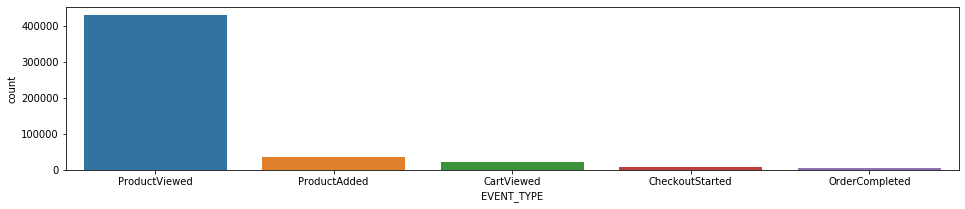

In [5]:
categorical_attributes = interactions_df.select_dtypes(include = ['object'])

plt.figure(figsize=(16,3))
sns.countplot(data = categorical_attributes, x = 'EVENT_TYPE')

#### Upload Data
Now we will upload the data we prepared to S3.

In [ ]:
boto3.Session().resource('s3').Bucket(bucket).Object(interactions_filename).upload_file(interactions_filename)

In [ ]:
boto3.Session().resource('s3').Bucket(bucket).Object(items_filename).upload_file(items_filename)

In [ ]:
boto3.Session().resource('s3').Bucket(bucket).Object(users_filename).upload_file(users_filename)

## Configure Amazon Personalize

Now that we've prepared our three datasets and uploaded them to S3 we'll need to configure the Amazon Personalize service to understand our data so that it can be used to train models for generating recommendations.

### Create Schemas for Datasets

Amazon Personalize requires a schema for each dataset so it can map the columns in our CSVs to fields for model training. Each schema is declared in JSON using the [Apache Avro](https://avro.apache.org/) format.

Let's define and create schemas in Personalize for our datasets.

#### Items Datsaset Schema

In [9]:
items_schema = {
    "type": "record",
    "name": "Items",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "CATEGORY",
            "type": "string",
            "categorical": True
        },
        {
            "name": "TYPE",
            "type": "string",
            "categorical": True
        },
        {
            "name": "SIZE",
            "type": "string",
            "categorical": True
        },
        {
            "name": "SUGAR",
            "type": "string",
            "categorical": True
        }
    ],
    "version": "1.0"
}

create_schema_response = personalize.create_schema(
    name = "cpg-schema-items-1",
    schema = json.dumps(items_schema)
)

items_schema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

{
  "schemaArn": "arn:aws:personalize:us-east-1:444208467160:schema/cpg-schema-items-1",
  "ResponseMetadata": {
    "RequestId": "748c8c10-0475-4ddf-acca-84253dfe2e00",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Thu, 04 Feb 2021 18:02:31 GMT",
      "x-amzn-requestid": "748c8c10-0475-4ddf-acca-84253dfe2e00",
      "content-length": "84",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Users Dataset Schema

In [10]:
users_schema = {
    "type": "record",
    "name": "Users",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "USER_ID",
            "type": "string"
        },
        {
            "name": "AGE",
            "type": "int"
        },
        {
            "name": "GENDER",
            "type": "string",
            "categorical": True
        }
    ],
    "version": "1.0"
}

create_schema_response = personalize.create_schema(
    name = "cpg-schema-users-1",
    schema = json.dumps(users_schema)
)



In [11]:
users_schema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

{
  "schemaArn": "arn:aws:personalize:us-east-1:444208467160:schema/cpg-schema-users-1",
  "ResponseMetadata": {
    "RequestId": "3d24fee5-2078-4b62-b8d0-63f126dc97da",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Thu, 04 Feb 2021 18:02:42 GMT",
      "x-amzn-requestid": "3d24fee5-2078-4b62-b8d0-63f126dc97da",
      "content-length": "84",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Interactions Dataset Schema

In [12]:
interactions_schema = {
    "type": "record",
    "name": "Interactions",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
            "name": "USER_ID",
            "type": "string"
        },
        {
            "name": "EVENT_TYPE",
            "type": "string"
        },
        {
            "name": "TIMESTAMP",
            "type": "long"
        },
        {
            "name": "ITEM_SUGAR_LEVEL",
            "type": "string",
            "categorical": True
        }
    ],
    "version": "1.0"
}

create_schema_response = personalize.create_schema(
    name = "cpg-schema-interactions-1",
    schema = json.dumps(interactions_schema)
)

interactions_schema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

{
  "schemaArn": "arn:aws:personalize:us-east-1:444208467160:schema/cpg-schema-interactions-1",
  "ResponseMetadata": {
    "RequestId": "79c3472d-6b5e-4fd6-96d0-5a43678e18f7",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Thu, 04 Feb 2021 18:03:19 GMT",
      "x-amzn-requestid": "79c3472d-6b5e-4fd6-96d0-5a43678e18f7",
      "content-length": "91",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Working in different sessions or connection issues. 
If you are doing the workshop in an AWS event or finishing it in single session please ignore this section. 
In case you lose connection or reset the kernel and want to resume from where you left it, a lot of the variables needs to be instantiated again, and usually are the arns of the resources you created before. Below an example.

In [ ]:
### Only if you are doing this in several sessions or restarted the kernel
#items_schema_arn = 'arn:aws:personalize:us-east-1:444208467160:schema/cpg-schema-items-v2'
#users_schema_arn = 'arn:aws:personalize:us-east-1:444208467160:schema/cpg-schema-users'
#interactions_schema_arn = 'arn:aws:personalize:us-east-1:444208467160:schema/cpg-interactions'


### Create and Wait for Dataset Group

Next we need to create the dataset group that will contain our three datasets.

#### Create Dataset Group

In [13]:
create_dataset_group_response = personalize.create_dataset_group(
    name = 'cgp-dataset'
)
dataset_group_arn = create_dataset_group_response['datasetGroupArn']
print(json.dumps(create_dataset_group_response, indent=2))

print(f'DatasetGroupArn = {dataset_group_arn}')

{
  "datasetGroupArn": "arn:aws:personalize:us-east-1:444208467160:dataset-group/cgp-dataset",
  "ResponseMetadata": {
    "RequestId": "6460bd72-3e85-48e7-803f-22ca026579a1",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Thu, 04 Feb 2021 18:03:39 GMT",
      "x-amzn-requestid": "6460bd72-3e85-48e7-803f-22ca026579a1",
      "content-length": "90",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}
DatasetGroupArn = arn:aws:personalize:us-east-1:444208467160:dataset-group/cgp-dataset


#### Wait for Dataset Group to Have ACTIVE Status

In [14]:
status = None
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_group_response = personalize.describe_dataset_group(
        datasetGroupArn = dataset_group_arn
    )
    status = describe_dataset_group_response["datasetGroup"]["status"]
    print("DatasetGroup: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(15)

DatasetGroup: CREATE PENDING
DatasetGroup: ACTIVE


### Create Items Dataset

Next we will create the datasets in Personalize for our three dataset types. Let's start with the items dataset.

In [15]:
dataset_type = "ITEMS"
create_dataset_response = personalize.create_dataset(
    name = "cpg-dataset-items",
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = items_schema_arn
)

items_dataset_arn = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))

{
  "datasetArn": "arn:aws:personalize:us-east-1:444208467160:dataset/cgp-dataset/ITEMS",
  "ResponseMetadata": {
    "RequestId": "6898db89-d5d2-4780-bdb0-f14eda9090bb",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Thu, 04 Feb 2021 18:36:40 GMT",
      "x-amzn-requestid": "6898db89-d5d2-4780-bdb0-f14eda9090bb",
      "content-length": "85",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


### Create Users Dataset

In [16]:
dataset_type = "USERS"
create_dataset_response = personalize.create_dataset(
    name = "cpg-dataset-users",
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = users_schema_arn
)

users_dataset_arn = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))

{
  "datasetArn": "arn:aws:personalize:us-east-1:444208467160:dataset/cgp-dataset/USERS",
  "ResponseMetadata": {
    "RequestId": "c602e6be-9fc0-4774-a0a1-bb205e883852",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Thu, 04 Feb 2021 18:36:43 GMT",
      "x-amzn-requestid": "c602e6be-9fc0-4774-a0a1-bb205e883852",
      "content-length": "85",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


### Create Interactions Dataset

In [17]:
dataset_type = "INTERACTIONS"
create_dataset_response = personalize.create_dataset(
    name = "cpg-dataset-interactions",
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = interactions_schema_arn
)

interactions_dataset_arn = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))

{
  "datasetArn": "arn:aws:personalize:us-east-1:444208467160:dataset/cgp-dataset/INTERACTIONS",
  "ResponseMetadata": {
    "RequestId": "244e386f-0114-4c05-8b38-5fdf7ba52caa",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Thu, 04 Feb 2021 18:36:47 GMT",
      "x-amzn-requestid": "244e386f-0114-4c05-8b38-5fdf7ba52caa",
      "content-length": "92",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


## Import Datasets to Personalize

Up to this point we have generated CSVs containing data for our users, items, and interactions and staged them in an S3 bucket. We also created schemas in Personalize that define the columns in our CSVs. Then we created a datset group and three datasets in Personalize that will receive our data. In the following steps we will create import jobs with Personalize that will import the datasets from our S3 bucket into the service.

### Setup Permissions

By default, the Personalize service does not have permission to acccess the data we uploaded into the S3 bucket in our account. In order to grant access to the  Personalize service to read our CSVs, we need to set a Bucket Policy and create an IAM role that the Amazon Personalize service will assume.

#### Attach policy to S3 bucket

In [ ]:
s3 = boto3.client("s3")

policy = {
    "Version": "2012-10-17",
    "Id": "PersonalizeS3BucketAccessPolicy",
    "Statement": [
        {
            "Sid": "PersonalizeS3BucketAccessPolicy",
            "Effect": "Allow",
            "Principal": {
                "Service": "personalize.amazonaws.com"
            },
            "Action": [
                "s3:GetObject",
                "s3:ListBucket"
            ],
            "Resource": [
                "arn:aws:s3:::{}".format(bucket),
                "arn:aws:s3:::{}/*".format(bucket)
            ]
        }
    ]
}

s3.put_bucket_policy(Bucket=bucket, Policy=json.dumps(policy));

#### Create S3 Read Only Access Role

In [ ]:
iam = boto3.client("iam")

role_name = 'CPG'+"-PersonalizeS3"
assume_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
          "Effect": "Allow",
          "Principal": {
            "Service": "personalize.amazonaws.com"
          },
          "Action": "sts:AssumeRole"
        }
    ]
}

create_role_response = iam.create_role(
    RoleName = role_name,
    AssumeRolePolicyDocument = json.dumps(assume_role_policy_document)
);

iam.attach_role_policy(
    RoleName = role_name,
    PolicyArn = "arn:aws:iam::aws:policy/AmazonS3ReadOnlyAccess"
);

role_arn = create_role_response["Role"]["Arn"]
print('IAM Role: {}'.format(role_arn))
# Pause to allow role to fully persist
time.sleep(10)

### Create Import Jobs

With the permissions in place to allow Personalize to access our CSV files, let's create three import jobs to import each file into its respective dataset. Each import job can take several minutes to complete so we'll create all three and then wait for them all to complete.

#### Create Items Dataset Import Job

In [18]:
## Only use the role if you are reusing without cleaning previous runs.
role_arn = 'arn:aws:iam::444208467160:role/CPG-PersonalizeS3'

items_create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "cpg-dataset-items-import-job",
    datasetArn = items_dataset_arn,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket, items_filename)
    },
    roleArn = role_arn
)

items_dataset_import_job_arn = items_create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(items_create_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:us-east-1:444208467160:dataset-import-job/cpg-dataset-items-import-job",
  "ResponseMetadata": {
    "RequestId": "2d89aac9-9148-4d45-8e72-ac71b3639417",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Thu, 04 Feb 2021 18:37:07 GMT",
      "x-amzn-requestid": "2d89aac9-9148-4d45-8e72-ac71b3639417",
      "content-length": "116",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Create Users Dataset Import Job

In [19]:
users_create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "cpg-dataset-users-import-job",
    datasetArn = users_dataset_arn,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket, users_filename)
    },
    roleArn = role_arn
)

users_dataset_import_job_arn = users_create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(users_create_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:us-east-1:444208467160:dataset-import-job/cpg-dataset-users-import-job",
  "ResponseMetadata": {
    "RequestId": "050e1165-6897-4695-a1b0-6af4ad4dcf17",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Thu, 04 Feb 2021 18:37:14 GMT",
      "x-amzn-requestid": "050e1165-6897-4695-a1b0-6af4ad4dcf17",
      "content-length": "116",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Create Interactions Dataset Import Job

In [20]:
interactions_create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "cpg-dataset-interactions-import-job",
    datasetArn = interactions_dataset_arn,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket, interactions_filename)
    },
    roleArn = role_arn
)

interactions_dataset_import_job_arn = interactions_create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(interactions_create_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:us-east-1:444208467160:dataset-import-job/cpg-dataset-interactions-import-job",
  "ResponseMetadata": {
    "RequestId": "e5b5692b-e7bf-480a-afc7-183a37032fdd",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Thu, 04 Feb 2021 18:37:17 GMT",
      "x-amzn-requestid": "e5b5692b-e7bf-480a-afc7-183a37032fdd",
      "content-length": "123",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


### Wait for Import Jobs to Complete

It will take 10-15 minutes for the import jobs to complete, while you're waiting you can learn more about Datasets and Schemas here: https://docs.aws.amazon.com/personalize/latest/dg/how-it-works-dataset-schema.html

We will wait for all three jobs to finish.

#### Wait for Items Import Job to Complete

In [21]:
%%time

import_job_arns = [ items_dataset_import_job_arn, users_dataset_import_job_arn, interactions_dataset_import_job_arn ]

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    for job_arn in reversed(import_job_arns):
        import_job_response = personalize.describe_dataset_import_job(
            datasetImportJobArn = job_arn
        )
        status = import_job_response["datasetImportJob"]['status']

        if status == "ACTIVE":
            print(f'Import job {job_arn} successfully completed')
            import_job_arns.remove(job_arn)
        elif status == "CREATE FAILED":
            print(f'Import job {job_arn} failed')
            if import_job_response.get('failureReason'):
                print('   Reason: ' + import_job_response['failureReason'])
            import_job_arns.remove(job_arn)

    if len(import_job_arns) > 0:
        print('At least one dataset import job still in progress')
        time.sleep(60)
    else:
        print("All import jobs have ended")
        break

At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
Import job arn:aws:personalize:us-east-1:444208467160:dataset-import-job/cpg-dataset-interactions-import-job successfully completed
At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
At least one dataset import job still in progress
Import job arn:aws:personalize:us-east-1:444208467160:dataset-import-job/cpg-dataset-users-import-job successfully com

### Congratulations you finished the data layer notebook

Now, lets store all the values needed to continue on the next notebook.

In [24]:
%store dataset_group_arn
%store items_dataset_arn
%store users_dataset_arn
%store interactions_dataset_arn
%store role_arn
%store users_dataset_import_job_arn
%store interactions_dataset_import_job_arn
%store items_dataset_import_job_arn

Stored 'dataset_group_arn' (str)
Stored 'items_dataset_arn' (str)
Stored 'users_dataset_arn' (str)
Stored 'interactions_dataset_arn' (str)
Stored 'role_arn' (str)
Stored 'users_dataset_import_job_arn' (str)
Stored 'interactions_dataset_import_job_arn' (str)
Stored 'items_dataset_import_job_arn' (str)
